# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

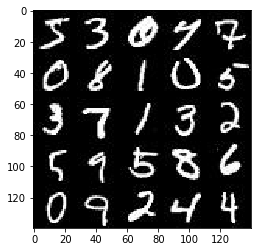

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

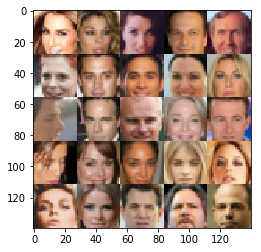

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    LR = tf.placeholder(tf.float32, shape=(), name='learning_rate')
    
    return inputs_real, inputs_z, LR


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [13]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.1  #leaky Relu, leak factor 
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128    
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [22]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.1     #leaky Relu, leak factor 
    
    with tf.variable_scope('generator', reuse=not(is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7,7,256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
             
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    label_smooth = 0.1

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=(1-label_smooth) * tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake   
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
  
    return  d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # Figure out dimensions from the input image shape tensor:
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    # Build the model now:
    input_real, input_z, LR = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)   
    
    
    samples, losses = [], []
    steps = 0
    print_every = 10
    show_every = 100
    n_images = 4

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % print_every == 0:
                    # At the end of every some many epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    _ = show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.3561... Generator Loss: 0.2764
Epoch 1/2... Discriminator Loss: 2.6865... Generator Loss: 0.2916
Epoch 1/2... Discriminator Loss: 2.1428... Generator Loss: 0.3576
Epoch 1/2... Discriminator Loss: 2.0047... Generator Loss: 0.3546
Epoch 1/2... Discriminator Loss: 1.8159... Generator Loss: 0.2905
Epoch 1/2... Discriminator Loss: 1.7920... Generator Loss: 0.7160
Epoch 1/2... Discriminator Loss: 1.9045... Generator Loss: 0.4047
Epoch 1/2... Discriminator Loss: 1.8371... Generator Loss: 0.9560
Epoch 1/2... Discriminator Loss: 1.5952... Generator Loss: 0.5378
Epoch 1/2... Discriminator Loss: 1.9498... Generator Loss: 1.0584


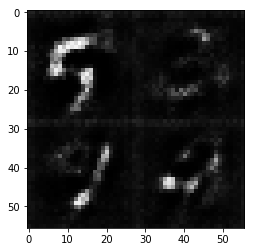

Epoch 1/2... Discriminator Loss: 1.5766... Generator Loss: 0.8616
Epoch 1/2... Discriminator Loss: 1.6929... Generator Loss: 0.8182
Epoch 1/2... Discriminator Loss: 1.6197... Generator Loss: 0.6256
Epoch 1/2... Discriminator Loss: 1.5914... Generator Loss: 0.7342
Epoch 1/2... Discriminator Loss: 1.8185... Generator Loss: 0.5331
Epoch 1/2... Discriminator Loss: 1.9222... Generator Loss: 0.4759
Epoch 1/2... Discriminator Loss: 1.8202... Generator Loss: 0.4503
Epoch 1/2... Discriminator Loss: 1.5641... Generator Loss: 0.5816
Epoch 1/2... Discriminator Loss: 1.5035... Generator Loss: 1.0343
Epoch 1/2... Discriminator Loss: 1.4762... Generator Loss: 0.7072


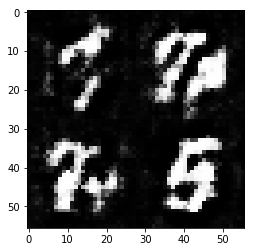

Epoch 1/2... Discriminator Loss: 1.6812... Generator Loss: 0.5055
Epoch 1/2... Discriminator Loss: 1.4536... Generator Loss: 1.0009
Epoch 1/2... Discriminator Loss: 1.1811... Generator Loss: 0.8188
Epoch 1/2... Discriminator Loss: 1.4822... Generator Loss: 0.5127
Epoch 1/2... Discriminator Loss: 1.6603... Generator Loss: 0.7581
Epoch 1/2... Discriminator Loss: 1.3562... Generator Loss: 1.4644
Epoch 1/2... Discriminator Loss: 1.5048... Generator Loss: 0.8797
Epoch 1/2... Discriminator Loss: 1.5454... Generator Loss: 0.5492
Epoch 1/2... Discriminator Loss: 1.4920... Generator Loss: 0.5069
Epoch 1/2... Discriminator Loss: 1.4251... Generator Loss: 0.6587


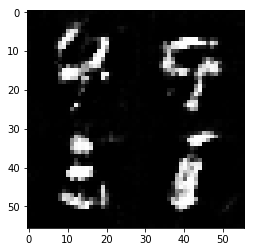

Epoch 1/2... Discriminator Loss: 1.2584... Generator Loss: 0.7400
Epoch 1/2... Discriminator Loss: 1.4204... Generator Loss: 0.7251
Epoch 1/2... Discriminator Loss: 1.7544... Generator Loss: 0.8779
Epoch 1/2... Discriminator Loss: 1.5092... Generator Loss: 0.6014
Epoch 1/2... Discriminator Loss: 1.2213... Generator Loss: 1.0749
Epoch 1/2... Discriminator Loss: 1.4290... Generator Loss: 0.6431
Epoch 1/2... Discriminator Loss: 1.6697... Generator Loss: 0.8859
Epoch 1/2... Discriminator Loss: 1.6968... Generator Loss: 0.3241
Epoch 1/2... Discriminator Loss: 1.2652... Generator Loss: 1.0622
Epoch 1/2... Discriminator Loss: 1.8189... Generator Loss: 0.4075


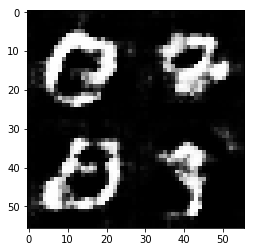

Epoch 1/2... Discriminator Loss: 1.6378... Generator Loss: 0.5632
Epoch 1/2... Discriminator Loss: 1.3732... Generator Loss: 0.6292
Epoch 1/2... Discriminator Loss: 1.6735... Generator Loss: 0.9149
Epoch 1/2... Discriminator Loss: 2.0048... Generator Loss: 0.3275
Epoch 1/2... Discriminator Loss: 1.6807... Generator Loss: 0.5219
Epoch 1/2... Discriminator Loss: 1.6231... Generator Loss: 0.6402
Epoch 1/2... Discriminator Loss: 1.4193... Generator Loss: 0.6821
Epoch 1/2... Discriminator Loss: 1.5490... Generator Loss: 0.6661
Epoch 1/2... Discriminator Loss: 1.6129... Generator Loss: 0.5752
Epoch 1/2... Discriminator Loss: 1.4442... Generator Loss: 0.7631


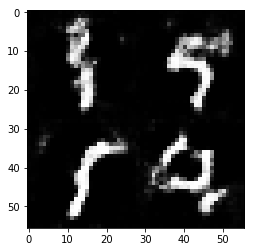

Epoch 1/2... Discriminator Loss: 1.6495... Generator Loss: 0.6031
Epoch 1/2... Discriminator Loss: 1.4894... Generator Loss: 0.7061
Epoch 1/2... Discriminator Loss: 1.8186... Generator Loss: 0.3430
Epoch 1/2... Discriminator Loss: 1.4859... Generator Loss: 0.7561
Epoch 1/2... Discriminator Loss: 1.3942... Generator Loss: 1.1351
Epoch 1/2... Discriminator Loss: 1.9357... Generator Loss: 0.9266
Epoch 1/2... Discriminator Loss: 1.5886... Generator Loss: 0.8038
Epoch 1/2... Discriminator Loss: 1.6107... Generator Loss: 0.7075
Epoch 1/2... Discriminator Loss: 1.4199... Generator Loss: 0.6570
Epoch 1/2... Discriminator Loss: 1.7272... Generator Loss: 0.4876


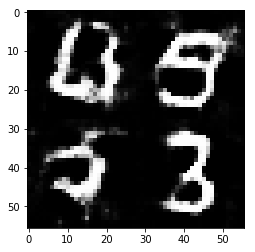

Epoch 1/2... Discriminator Loss: 1.6762... Generator Loss: 0.6121
Epoch 1/2... Discriminator Loss: 1.4187... Generator Loss: 0.7187
Epoch 1/2... Discriminator Loss: 1.6641... Generator Loss: 0.5167
Epoch 1/2... Discriminator Loss: 1.5829... Generator Loss: 0.7037
Epoch 1/2... Discriminator Loss: 1.6052... Generator Loss: 0.5692
Epoch 1/2... Discriminator Loss: 1.4054... Generator Loss: 0.7239
Epoch 1/2... Discriminator Loss: 1.6306... Generator Loss: 0.6002
Epoch 1/2... Discriminator Loss: 1.3760... Generator Loss: 0.8013
Epoch 1/2... Discriminator Loss: 1.7581... Generator Loss: 0.7972
Epoch 1/2... Discriminator Loss: 1.2644... Generator Loss: 0.7366


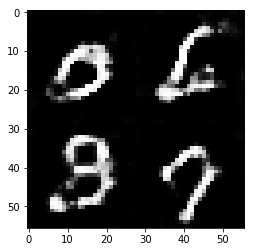

Epoch 1/2... Discriminator Loss: 1.6308... Generator Loss: 0.5378
Epoch 1/2... Discriminator Loss: 1.7557... Generator Loss: 0.4253
Epoch 1/2... Discriminator Loss: 1.5981... Generator Loss: 0.8996
Epoch 1/2... Discriminator Loss: 1.4926... Generator Loss: 0.6359
Epoch 1/2... Discriminator Loss: 1.2998... Generator Loss: 0.7529
Epoch 1/2... Discriminator Loss: 1.0997... Generator Loss: 0.7865
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7247
Epoch 1/2... Discriminator Loss: 1.4907... Generator Loss: 0.7394
Epoch 1/2... Discriminator Loss: 1.4284... Generator Loss: 0.7360
Epoch 1/2... Discriminator Loss: 1.9124... Generator Loss: 0.3378


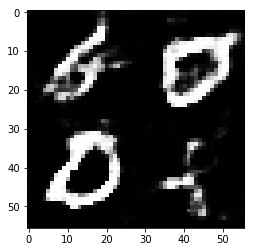

Epoch 1/2... Discriminator Loss: 1.4990... Generator Loss: 0.5826
Epoch 1/2... Discriminator Loss: 1.7365... Generator Loss: 0.6174
Epoch 1/2... Discriminator Loss: 1.4385... Generator Loss: 0.4814
Epoch 1/2... Discriminator Loss: 1.3369... Generator Loss: 1.0203
Epoch 1/2... Discriminator Loss: 1.8380... Generator Loss: 0.3852
Epoch 1/2... Discriminator Loss: 1.6467... Generator Loss: 0.7227
Epoch 1/2... Discriminator Loss: 1.4448... Generator Loss: 0.6964
Epoch 1/2... Discriminator Loss: 1.7579... Generator Loss: 0.4955
Epoch 1/2... Discriminator Loss: 1.5943... Generator Loss: 0.8285
Epoch 1/2... Discriminator Loss: 1.4403... Generator Loss: 0.6468


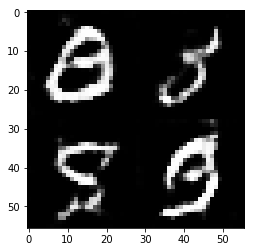

Epoch 1/2... Discriminator Loss: 1.6472... Generator Loss: 0.7608
Epoch 1/2... Discriminator Loss: 1.5860... Generator Loss: 0.7726
Epoch 1/2... Discriminator Loss: 1.3854... Generator Loss: 0.8125
Epoch 1/2... Discriminator Loss: 1.6871... Generator Loss: 0.5742
Epoch 1/2... Discriminator Loss: 1.2108... Generator Loss: 0.8928
Epoch 1/2... Discriminator Loss: 1.5335... Generator Loss: 0.7236
Epoch 1/2... Discriminator Loss: 1.5041... Generator Loss: 0.5661
Epoch 1/2... Discriminator Loss: 1.3303... Generator Loss: 0.8067
Epoch 1/2... Discriminator Loss: 1.6267... Generator Loss: 0.5937
Epoch 1/2... Discriminator Loss: 1.6106... Generator Loss: 0.5701


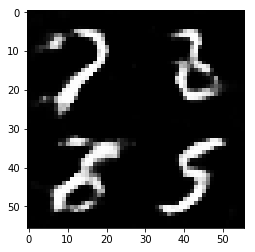

Epoch 1/2... Discriminator Loss: 1.5506... Generator Loss: 0.4403
Epoch 1/2... Discriminator Loss: 1.2990... Generator Loss: 1.0692
Epoch 1/2... Discriminator Loss: 1.2080... Generator Loss: 0.7962
Epoch 1/2... Discriminator Loss: 1.5147... Generator Loss: 0.8689
Epoch 1/2... Discriminator Loss: 1.4695... Generator Loss: 0.5907
Epoch 1/2... Discriminator Loss: 1.3614... Generator Loss: 0.9660
Epoch 1/2... Discriminator Loss: 1.6988... Generator Loss: 0.4781
Epoch 1/2... Discriminator Loss: 1.5165... Generator Loss: 0.5215
Epoch 1/2... Discriminator Loss: 1.3825... Generator Loss: 0.8041
Epoch 1/2... Discriminator Loss: 1.5543... Generator Loss: 0.4573


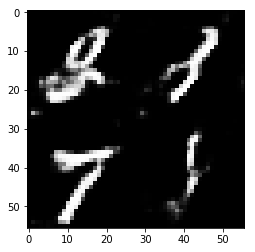

Epoch 1/2... Discriminator Loss: 1.3615... Generator Loss: 0.8514
Epoch 1/2... Discriminator Loss: 1.5074... Generator Loss: 0.5822
Epoch 1/2... Discriminator Loss: 1.6240... Generator Loss: 0.6095
Epoch 1/2... Discriminator Loss: 1.5330... Generator Loss: 0.6232
Epoch 1/2... Discriminator Loss: 1.4592... Generator Loss: 0.5800
Epoch 1/2... Discriminator Loss: 1.5471... Generator Loss: 0.5557
Epoch 1/2... Discriminator Loss: 1.6087... Generator Loss: 0.5116
Epoch 1/2... Discriminator Loss: 1.4378... Generator Loss: 0.8209
Epoch 1/2... Discriminator Loss: 1.4336... Generator Loss: 0.9186
Epoch 1/2... Discriminator Loss: 1.5060... Generator Loss: 0.5882


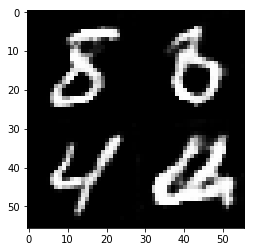

Epoch 1/2... Discriminator Loss: 1.4951... Generator Loss: 0.6896
Epoch 1/2... Discriminator Loss: 1.4393... Generator Loss: 0.8361
Epoch 1/2... Discriminator Loss: 1.5845... Generator Loss: 0.6243
Epoch 1/2... Discriminator Loss: 1.3443... Generator Loss: 0.6985
Epoch 1/2... Discriminator Loss: 1.5363... Generator Loss: 0.9124
Epoch 1/2... Discriminator Loss: 1.4825... Generator Loss: 0.5737
Epoch 1/2... Discriminator Loss: 1.4895... Generator Loss: 0.5659
Epoch 1/2... Discriminator Loss: 1.2698... Generator Loss: 0.6259
Epoch 1/2... Discriminator Loss: 1.3069... Generator Loss: 0.7620
Epoch 1/2... Discriminator Loss: 1.6336... Generator Loss: 0.5839


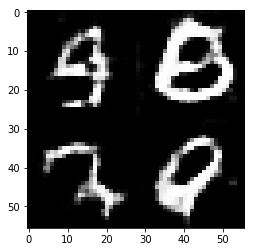

Epoch 1/2... Discriminator Loss: 1.4052... Generator Loss: 0.7566
Epoch 1/2... Discriminator Loss: 1.7181... Generator Loss: 0.5908
Epoch 1/2... Discriminator Loss: 1.2799... Generator Loss: 0.9455
Epoch 1/2... Discriminator Loss: 1.3429... Generator Loss: 1.0793
Epoch 1/2... Discriminator Loss: 1.5715... Generator Loss: 0.4774
Epoch 1/2... Discriminator Loss: 1.5732... Generator Loss: 0.6621
Epoch 1/2... Discriminator Loss: 1.6622... Generator Loss: 0.4292
Epoch 1/2... Discriminator Loss: 1.4598... Generator Loss: 0.7293
Epoch 1/2... Discriminator Loss: 1.3236... Generator Loss: 0.7611
Epoch 1/2... Discriminator Loss: 2.1643... Generator Loss: 0.2955


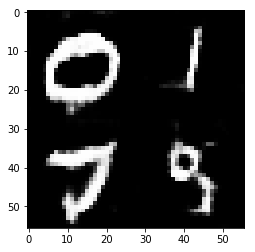

Epoch 1/2... Discriminator Loss: 1.5392... Generator Loss: 0.7567
Epoch 1/2... Discriminator Loss: 1.5510... Generator Loss: 0.5157
Epoch 1/2... Discriminator Loss: 1.6416... Generator Loss: 0.5197
Epoch 1/2... Discriminator Loss: 1.4840... Generator Loss: 0.5273
Epoch 1/2... Discriminator Loss: 1.6156... Generator Loss: 0.4674
Epoch 1/2... Discriminator Loss: 1.3078... Generator Loss: 0.6059
Epoch 1/2... Discriminator Loss: 1.5136... Generator Loss: 0.6538
Epoch 1/2... Discriminator Loss: 1.5445... Generator Loss: 1.1361
Epoch 1/2... Discriminator Loss: 1.3577... Generator Loss: 0.7027
Epoch 1/2... Discriminator Loss: 1.4817... Generator Loss: 1.0731


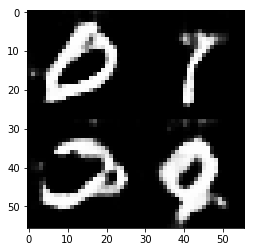

Epoch 1/2... Discriminator Loss: 1.4713... Generator Loss: 0.7421
Epoch 1/2... Discriminator Loss: 1.3470... Generator Loss: 1.1463
Epoch 1/2... Discriminator Loss: 1.7546... Generator Loss: 0.3941
Epoch 1/2... Discriminator Loss: 1.4923... Generator Loss: 0.9069
Epoch 1/2... Discriminator Loss: 2.1017... Generator Loss: 0.3064
Epoch 1/2... Discriminator Loss: 1.4950... Generator Loss: 0.6598
Epoch 1/2... Discriminator Loss: 1.3691... Generator Loss: 0.6814
Epoch 1/2... Discriminator Loss: 1.6915... Generator Loss: 0.5462
Epoch 1/2... Discriminator Loss: 1.1341... Generator Loss: 1.3408
Epoch 1/2... Discriminator Loss: 1.4414... Generator Loss: 0.5069


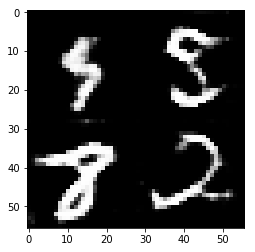

Epoch 1/2... Discriminator Loss: 1.3632... Generator Loss: 0.5421
Epoch 1/2... Discriminator Loss: 1.4611... Generator Loss: 0.5524
Epoch 1/2... Discriminator Loss: 1.3608... Generator Loss: 0.7972
Epoch 1/2... Discriminator Loss: 1.4571... Generator Loss: 0.5971
Epoch 1/2... Discriminator Loss: 1.2705... Generator Loss: 0.9190
Epoch 1/2... Discriminator Loss: 1.4178... Generator Loss: 0.6437
Epoch 1/2... Discriminator Loss: 1.4132... Generator Loss: 0.8881
Epoch 1/2... Discriminator Loss: 0.9365... Generator Loss: 0.9984
Epoch 1/2... Discriminator Loss: 2.5592... Generator Loss: 0.1732
Epoch 1/2... Discriminator Loss: 1.3901... Generator Loss: 0.6008


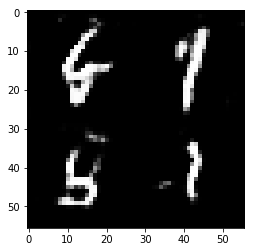

Epoch 1/2... Discriminator Loss: 1.0869... Generator Loss: 0.9786
Epoch 1/2... Discriminator Loss: 1.2696... Generator Loss: 1.0129
Epoch 1/2... Discriminator Loss: 1.3150... Generator Loss: 0.6621
Epoch 1/2... Discriminator Loss: 1.3196... Generator Loss: 0.7465
Epoch 1/2... Discriminator Loss: 1.3582... Generator Loss: 0.6614
Epoch 1/2... Discriminator Loss: 1.2681... Generator Loss: 0.7765
Epoch 1/2... Discriminator Loss: 1.4274... Generator Loss: 0.7687
Epoch 1/2... Discriminator Loss: 1.4116... Generator Loss: 0.8355
Epoch 1/2... Discriminator Loss: 1.0234... Generator Loss: 1.0963
Epoch 1/2... Discriminator Loss: 1.4272... Generator Loss: 0.5616


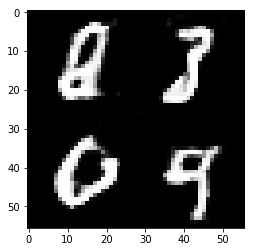

Epoch 1/2... Discriminator Loss: 1.3489... Generator Loss: 0.4741
Epoch 1/2... Discriminator Loss: 1.4105... Generator Loss: 0.8055
Epoch 1/2... Discriminator Loss: 1.4143... Generator Loss: 0.6161
Epoch 1/2... Discriminator Loss: 1.2908... Generator Loss: 0.6776
Epoch 1/2... Discriminator Loss: 1.4801... Generator Loss: 0.7571
Epoch 1/2... Discriminator Loss: 1.6221... Generator Loss: 0.4508
Epoch 1/2... Discriminator Loss: 1.4414... Generator Loss: 0.6108
Epoch 2/2... Discriminator Loss: 1.4510... Generator Loss: 0.6996
Epoch 2/2... Discriminator Loss: 1.3712... Generator Loss: 0.8448
Epoch 2/2... Discriminator Loss: 1.4106... Generator Loss: 0.9874


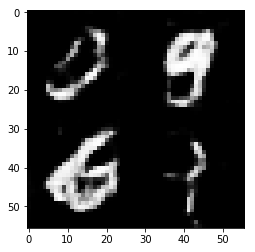

Epoch 2/2... Discriminator Loss: 1.4108... Generator Loss: 0.7584
Epoch 2/2... Discriminator Loss: 1.4617... Generator Loss: 0.5073
Epoch 2/2... Discriminator Loss: 1.2198... Generator Loss: 0.6991
Epoch 2/2... Discriminator Loss: 1.3332... Generator Loss: 0.8254
Epoch 2/2... Discriminator Loss: 1.2695... Generator Loss: 0.7035
Epoch 2/2... Discriminator Loss: 1.5218... Generator Loss: 0.6775
Epoch 2/2... Discriminator Loss: 1.6803... Generator Loss: 0.4321
Epoch 2/2... Discriminator Loss: 1.1009... Generator Loss: 0.8379
Epoch 2/2... Discriminator Loss: 1.2084... Generator Loss: 0.9073
Epoch 2/2... Discriminator Loss: 1.5321... Generator Loss: 0.5280


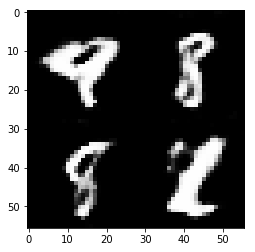

Epoch 2/2... Discriminator Loss: 1.2771... Generator Loss: 0.5504
Epoch 2/2... Discriminator Loss: 1.0812... Generator Loss: 0.8282
Epoch 2/2... Discriminator Loss: 1.3908... Generator Loss: 1.1411
Epoch 2/2... Discriminator Loss: 1.1848... Generator Loss: 0.8668
Epoch 2/2... Discriminator Loss: 1.4246... Generator Loss: 0.8781
Epoch 2/2... Discriminator Loss: 1.3673... Generator Loss: 0.7405
Epoch 2/2... Discriminator Loss: 1.7132... Generator Loss: 0.4268
Epoch 2/2... Discriminator Loss: 1.4667... Generator Loss: 0.4107
Epoch 2/2... Discriminator Loss: 1.5525... Generator Loss: 0.5818
Epoch 2/2... Discriminator Loss: 1.2782... Generator Loss: 1.0419


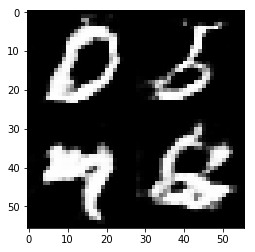

Epoch 2/2... Discriminator Loss: 1.4351... Generator Loss: 0.5530
Epoch 2/2... Discriminator Loss: 1.1631... Generator Loss: 0.9863
Epoch 2/2... Discriminator Loss: 1.4402... Generator Loss: 0.5922
Epoch 2/2... Discriminator Loss: 1.0661... Generator Loss: 1.0216
Epoch 2/2... Discriminator Loss: 1.2521... Generator Loss: 0.7988
Epoch 2/2... Discriminator Loss: 2.8351... Generator Loss: 0.1281
Epoch 2/2... Discriminator Loss: 1.4362... Generator Loss: 0.6279
Epoch 2/2... Discriminator Loss: 1.4810... Generator Loss: 0.8190
Epoch 2/2... Discriminator Loss: 0.9964... Generator Loss: 0.9413
Epoch 2/2... Discriminator Loss: 1.2427... Generator Loss: 0.8016


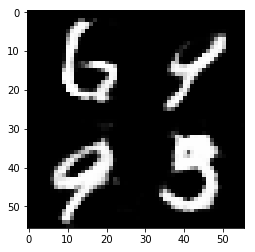

Epoch 2/2... Discriminator Loss: 1.3528... Generator Loss: 0.8038
Epoch 2/2... Discriminator Loss: 1.5471... Generator Loss: 0.7467
Epoch 2/2... Discriminator Loss: 1.6802... Generator Loss: 1.2469
Epoch 2/2... Discriminator Loss: 1.1160... Generator Loss: 0.7487
Epoch 2/2... Discriminator Loss: 1.3802... Generator Loss: 0.5162
Epoch 2/2... Discriminator Loss: 1.1085... Generator Loss: 0.7831
Epoch 2/2... Discriminator Loss: 1.5376... Generator Loss: 0.6818
Epoch 2/2... Discriminator Loss: 0.9782... Generator Loss: 0.9306
Epoch 2/2... Discriminator Loss: 1.7296... Generator Loss: 0.5374
Epoch 2/2... Discriminator Loss: 1.0320... Generator Loss: 1.1340


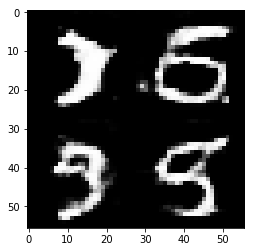

Epoch 2/2... Discriminator Loss: 1.6069... Generator Loss: 0.4921
Epoch 2/2... Discriminator Loss: 1.1993... Generator Loss: 0.6054
Epoch 2/2... Discriminator Loss: 1.4106... Generator Loss: 0.6653
Epoch 2/2... Discriminator Loss: 1.6932... Generator Loss: 0.4451
Epoch 2/2... Discriminator Loss: 1.0429... Generator Loss: 1.5327
Epoch 2/2... Discriminator Loss: 1.2132... Generator Loss: 0.6825
Epoch 2/2... Discriminator Loss: 1.2123... Generator Loss: 1.2206
Epoch 2/2... Discriminator Loss: 1.7314... Generator Loss: 0.3961
Epoch 2/2... Discriminator Loss: 1.1618... Generator Loss: 0.6946
Epoch 2/2... Discriminator Loss: 1.3441... Generator Loss: 0.6040


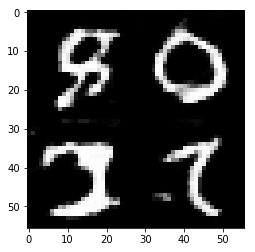

Epoch 2/2... Discriminator Loss: 1.3894... Generator Loss: 0.5736
Epoch 2/2... Discriminator Loss: 0.9523... Generator Loss: 1.2400
Epoch 2/2... Discriminator Loss: 1.3334... Generator Loss: 0.8371
Epoch 2/2... Discriminator Loss: 1.5758... Generator Loss: 0.8339
Epoch 2/2... Discriminator Loss: 1.2530... Generator Loss: 0.6453
Epoch 2/2... Discriminator Loss: 1.2771... Generator Loss: 0.8350
Epoch 2/2... Discriminator Loss: 1.6104... Generator Loss: 0.7076
Epoch 2/2... Discriminator Loss: 1.2917... Generator Loss: 0.4515
Epoch 2/2... Discriminator Loss: 1.2372... Generator Loss: 0.8248
Epoch 2/2... Discriminator Loss: 1.4497... Generator Loss: 0.4745


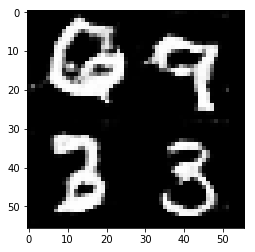

Epoch 2/2... Discriminator Loss: 1.6305... Generator Loss: 1.0315
Epoch 2/2... Discriminator Loss: 1.0660... Generator Loss: 0.9931
Epoch 2/2... Discriminator Loss: 1.1669... Generator Loss: 1.0149
Epoch 2/2... Discriminator Loss: 1.0793... Generator Loss: 0.7292
Epoch 2/2... Discriminator Loss: 1.4575... Generator Loss: 0.4964
Epoch 2/2... Discriminator Loss: 1.7637... Generator Loss: 0.4713
Epoch 2/2... Discriminator Loss: 1.4099... Generator Loss: 0.6629
Epoch 2/2... Discriminator Loss: 2.1362... Generator Loss: 0.3226
Epoch 2/2... Discriminator Loss: 0.8522... Generator Loss: 1.1433
Epoch 2/2... Discriminator Loss: 1.5899... Generator Loss: 0.4022


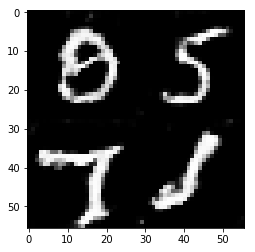

Epoch 2/2... Discriminator Loss: 1.1125... Generator Loss: 1.1092
Epoch 2/2... Discriminator Loss: 0.9564... Generator Loss: 0.9706
Epoch 2/2... Discriminator Loss: 0.9416... Generator Loss: 1.3107
Epoch 2/2... Discriminator Loss: 1.4651... Generator Loss: 0.5064
Epoch 2/2... Discriminator Loss: 1.6157... Generator Loss: 0.6508
Epoch 2/2... Discriminator Loss: 1.5117... Generator Loss: 0.8397
Epoch 2/2... Discriminator Loss: 0.9655... Generator Loss: 1.1485
Epoch 2/2... Discriminator Loss: 0.9248... Generator Loss: 0.8748
Epoch 2/2... Discriminator Loss: 1.2073... Generator Loss: 0.8283
Epoch 2/2... Discriminator Loss: 1.4467... Generator Loss: 0.7971


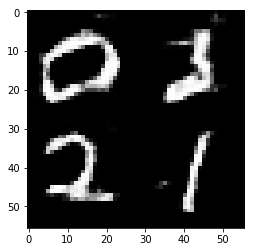

Epoch 2/2... Discriminator Loss: 1.1657... Generator Loss: 0.7078
Epoch 2/2... Discriminator Loss: 1.5253... Generator Loss: 0.6480
Epoch 2/2... Discriminator Loss: 1.6459... Generator Loss: 0.3644
Epoch 2/2... Discriminator Loss: 1.1720... Generator Loss: 1.3879
Epoch 2/2... Discriminator Loss: 1.0066... Generator Loss: 0.9445
Epoch 2/2... Discriminator Loss: 1.0758... Generator Loss: 1.0792
Epoch 2/2... Discriminator Loss: 1.1581... Generator Loss: 0.9345
Epoch 2/2... Discriminator Loss: 1.0741... Generator Loss: 0.8397
Epoch 2/2... Discriminator Loss: 1.4576... Generator Loss: 0.5626
Epoch 2/2... Discriminator Loss: 1.0481... Generator Loss: 1.0367


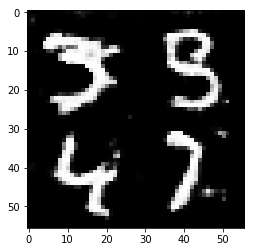

Epoch 2/2... Discriminator Loss: 1.2045... Generator Loss: 0.7285
Epoch 2/2... Discriminator Loss: 1.3694... Generator Loss: 0.7241
Epoch 2/2... Discriminator Loss: 0.8057... Generator Loss: 1.0551
Epoch 2/2... Discriminator Loss: 1.2895... Generator Loss: 1.1777
Epoch 2/2... Discriminator Loss: 1.3794... Generator Loss: 0.5584
Epoch 2/2... Discriminator Loss: 1.2227... Generator Loss: 0.7131
Epoch 2/2... Discriminator Loss: 1.3724... Generator Loss: 0.6962
Epoch 2/2... Discriminator Loss: 1.1000... Generator Loss: 0.6100
Epoch 2/2... Discriminator Loss: 1.5683... Generator Loss: 0.4605
Epoch 2/2... Discriminator Loss: 1.2034... Generator Loss: 1.0042


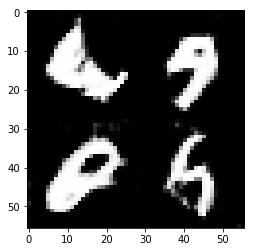

Epoch 2/2... Discriminator Loss: 1.0857... Generator Loss: 0.8814
Epoch 2/2... Discriminator Loss: 3.0729... Generator Loss: 0.1327
Epoch 2/2... Discriminator Loss: 0.9708... Generator Loss: 1.0990
Epoch 2/2... Discriminator Loss: 0.9230... Generator Loss: 0.9536
Epoch 2/2... Discriminator Loss: 1.2417... Generator Loss: 0.6343
Epoch 2/2... Discriminator Loss: 1.8722... Generator Loss: 0.3774
Epoch 2/2... Discriminator Loss: 1.4561... Generator Loss: 0.5656
Epoch 2/2... Discriminator Loss: 1.3437... Generator Loss: 0.6963
Epoch 2/2... Discriminator Loss: 1.1251... Generator Loss: 0.9705
Epoch 2/2... Discriminator Loss: 1.0859... Generator Loss: 0.8323


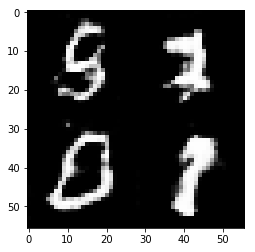

Epoch 2/2... Discriminator Loss: 1.7086... Generator Loss: 0.5240
Epoch 2/2... Discriminator Loss: 1.3060... Generator Loss: 0.7091
Epoch 2/2... Discriminator Loss: 1.0357... Generator Loss: 0.8542
Epoch 2/2... Discriminator Loss: 1.2652... Generator Loss: 0.6020
Epoch 2/2... Discriminator Loss: 1.0824... Generator Loss: 0.7135
Epoch 2/2... Discriminator Loss: 1.0970... Generator Loss: 0.7819
Epoch 2/2... Discriminator Loss: 0.8503... Generator Loss: 1.3874
Epoch 2/2... Discriminator Loss: 2.3845... Generator Loss: 0.2766
Epoch 2/2... Discriminator Loss: 1.2812... Generator Loss: 1.2667
Epoch 2/2... Discriminator Loss: 0.9279... Generator Loss: 1.2048


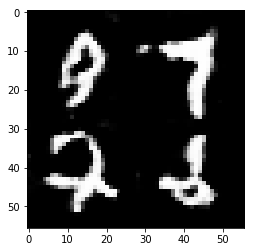

Epoch 2/2... Discriminator Loss: 1.1445... Generator Loss: 0.8327
Epoch 2/2... Discriminator Loss: 0.9160... Generator Loss: 1.5684
Epoch 2/2... Discriminator Loss: 1.8500... Generator Loss: 0.2548
Epoch 2/2... Discriminator Loss: 1.4464... Generator Loss: 0.5960
Epoch 2/2... Discriminator Loss: 1.0537... Generator Loss: 0.6435
Epoch 2/2... Discriminator Loss: 1.9010... Generator Loss: 0.2761
Epoch 2/2... Discriminator Loss: 1.2305... Generator Loss: 0.9609
Epoch 2/2... Discriminator Loss: 1.2449... Generator Loss: 0.5842
Epoch 2/2... Discriminator Loss: 1.6771... Generator Loss: 0.4053
Epoch 2/2... Discriminator Loss: 0.8225... Generator Loss: 1.2017


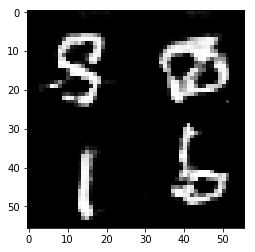

Epoch 2/2... Discriminator Loss: 1.1367... Generator Loss: 1.2089
Epoch 2/2... Discriminator Loss: 1.2248... Generator Loss: 0.6996
Epoch 2/2... Discriminator Loss: 1.6164... Generator Loss: 1.6133
Epoch 2/2... Discriminator Loss: 0.8811... Generator Loss: 1.3294
Epoch 2/2... Discriminator Loss: 1.6041... Generator Loss: 0.5404
Epoch 2/2... Discriminator Loss: 1.1968... Generator Loss: 0.7816
Epoch 2/2... Discriminator Loss: 0.9061... Generator Loss: 1.0754
Epoch 2/2... Discriminator Loss: 1.6343... Generator Loss: 0.4442
Epoch 2/2... Discriminator Loss: 1.3335... Generator Loss: 0.5055
Epoch 2/2... Discriminator Loss: 1.0528... Generator Loss: 1.1508


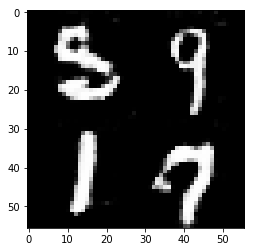

Epoch 2/2... Discriminator Loss: 1.1651... Generator Loss: 0.8132
Epoch 2/2... Discriminator Loss: 1.3450... Generator Loss: 0.7962
Epoch 2/2... Discriminator Loss: 1.1955... Generator Loss: 0.7340
Epoch 2/2... Discriminator Loss: 1.2315... Generator Loss: 0.5460
Epoch 2/2... Discriminator Loss: 1.0707... Generator Loss: 0.7475
Epoch 2/2... Discriminator Loss: 1.2940... Generator Loss: 0.8035
Epoch 2/2... Discriminator Loss: 1.1453... Generator Loss: 0.8370
Epoch 2/2... Discriminator Loss: 1.5488... Generator Loss: 0.5372
Epoch 2/2... Discriminator Loss: 1.1889... Generator Loss: 0.8599
Epoch 2/2... Discriminator Loss: 1.3700... Generator Loss: 0.9520


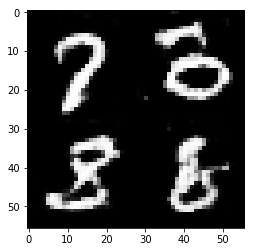

Epoch 2/2... Discriminator Loss: 0.9579... Generator Loss: 1.0771
Epoch 2/2... Discriminator Loss: 1.5710... Generator Loss: 0.4469
Epoch 2/2... Discriminator Loss: 0.8345... Generator Loss: 1.1807
Epoch 2/2... Discriminator Loss: 1.3655... Generator Loss: 0.6269
Epoch 2/2... Discriminator Loss: 1.0645... Generator Loss: 0.7402
Epoch 2/2... Discriminator Loss: 1.0099... Generator Loss: 1.1188
Epoch 2/2... Discriminator Loss: 1.4782... Generator Loss: 0.6800
Epoch 2/2... Discriminator Loss: 1.1655... Generator Loss: 1.0860
Epoch 2/2... Discriminator Loss: 1.1380... Generator Loss: 0.7120
Epoch 2/2... Discriminator Loss: 1.1394... Generator Loss: 1.4215


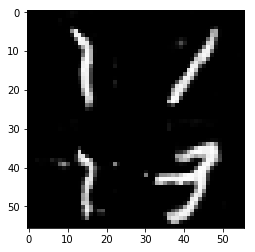

Epoch 2/2... Discriminator Loss: 2.0027... Generator Loss: 0.3765
Epoch 2/2... Discriminator Loss: 0.8427... Generator Loss: 1.1894
Epoch 2/2... Discriminator Loss: 1.5308... Generator Loss: 0.3700
Epoch 2/2... Discriminator Loss: 0.8549... Generator Loss: 1.6484
Epoch 2/2... Discriminator Loss: 1.2322... Generator Loss: 0.8305
Epoch 2/2... Discriminator Loss: 1.3775... Generator Loss: 0.8610
Epoch 2/2... Discriminator Loss: 1.2102... Generator Loss: 1.0460
Epoch 2/2... Discriminator Loss: 1.3648... Generator Loss: 0.5200
Epoch 2/2... Discriminator Loss: 2.4139... Generator Loss: 0.1971
Epoch 2/2... Discriminator Loss: 1.3736... Generator Loss: 0.7630


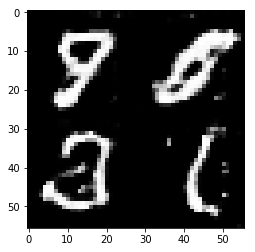

Epoch 2/2... Discriminator Loss: 0.9216... Generator Loss: 1.0218
Epoch 2/2... Discriminator Loss: 1.2067... Generator Loss: 0.8175
Epoch 2/2... Discriminator Loss: 0.8824... Generator Loss: 1.0927
Epoch 2/2... Discriminator Loss: 1.3808... Generator Loss: 0.4227
Epoch 2/2... Discriminator Loss: 0.7739... Generator Loss: 1.8172
Epoch 2/2... Discriminator Loss: 2.2610... Generator Loss: 0.3118
Epoch 2/2... Discriminator Loss: 1.7217... Generator Loss: 0.5331
Epoch 2/2... Discriminator Loss: 1.4669... Generator Loss: 0.5684
Epoch 2/2... Discriminator Loss: 1.5167... Generator Loss: 0.4377
Epoch 2/2... Discriminator Loss: 0.9991... Generator Loss: 1.3306


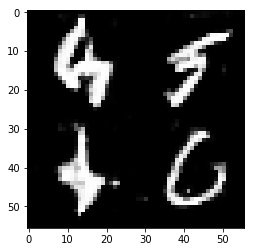

Epoch 2/2... Discriminator Loss: 1.0681... Generator Loss: 1.0202
Epoch 2/2... Discriminator Loss: 0.9770... Generator Loss: 0.9112
Epoch 2/2... Discriminator Loss: 0.7840... Generator Loss: 1.1452
Epoch 2/2... Discriminator Loss: 1.2577... Generator Loss: 0.5679
Epoch 2/2... Discriminator Loss: 1.2766... Generator Loss: 0.8794


In [23]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)


## REFERENCES ON MNIST HYPER PARAMETERS

I would like to give credit to my peers and their SLACK FORUM discussion on hyper-parameter tuning for Project 5 MNIST section above.

Two recommendations turned out to be very helpful. 
1. Keeping the batch_size small (I tried 64, then 32) due to fact that epochs were limited to 2.
2. Repating the optimization for generator multiple times within the 'training' section.

MNIST results appear to be good where Generator_Loss < Discriminator_Los for most of the times displayed above.


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.3181... Generator Loss: 0.3446
Epoch 1/1... Discriminator Loss: 2.1034... Generator Loss: 0.3817
Epoch 1/1... Discriminator Loss: 2.2243... Generator Loss: 0.2930
Epoch 1/1... Discriminator Loss: 2.0177... Generator Loss: 0.4642
Epoch 1/1... Discriminator Loss: 2.3889... Generator Loss: 0.3575
Epoch 1/1... Discriminator Loss: 2.2969... Generator Loss: 0.5056
Epoch 1/1... Discriminator Loss: 2.2671... Generator Loss: 0.4419
Epoch 1/1... Discriminator Loss: 1.9988... Generator Loss: 0.5248
Epoch 1/1... Discriminator Loss: 1.9476... Generator Loss: 0.4988
Epoch 1/1... Discriminator Loss: 1.7636... Generator Loss: 0.6046


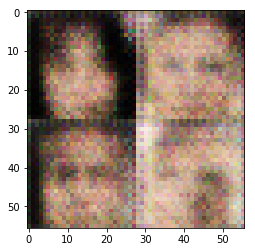

Epoch 1/1... Discriminator Loss: 1.8368... Generator Loss: 0.4699
Epoch 1/1... Discriminator Loss: 1.5534... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.6648... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.7655... Generator Loss: 0.5440
Epoch 1/1... Discriminator Loss: 2.1028... Generator Loss: 0.4141
Epoch 1/1... Discriminator Loss: 1.9463... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 1.6090... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.5577... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.6244... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.6705... Generator Loss: 0.6092


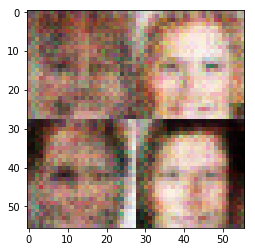

Epoch 1/1... Discriminator Loss: 1.4969... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.6420... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.5835... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.8477... Generator Loss: 0.5396
Epoch 1/1... Discriminator Loss: 1.5764... Generator Loss: 0.5361
Epoch 1/1... Discriminator Loss: 2.0846... Generator Loss: 0.3895
Epoch 1/1... Discriminator Loss: 1.8258... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.6252... Generator Loss: 0.5382
Epoch 1/1... Discriminator Loss: 1.7260... Generator Loss: 0.5593


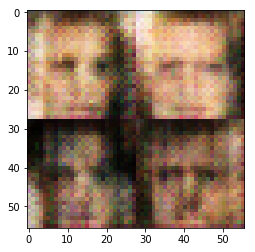

Epoch 1/1... Discriminator Loss: 1.6162... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.6596... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.6970... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.8581... Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 1.5940... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 1.6892... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 1.6066... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.7186... Generator Loss: 0.6040
Epoch 1/1... Discriminator Loss: 1.6033... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.6109... Generator Loss: 0.6184


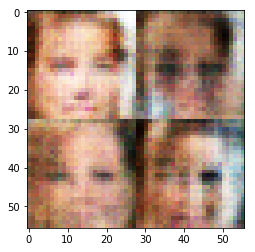

Epoch 1/1... Discriminator Loss: 1.5310... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 0.5946
Epoch 1/1... Discriminator Loss: 1.5278... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.5161... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.5237... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.5632... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.5414... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.5463... Generator Loss: 0.6524


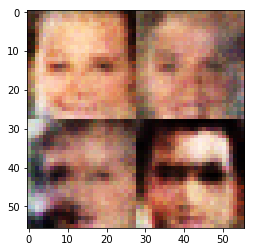

Epoch 1/1... Discriminator Loss: 1.5998... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.5734... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.5124... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.5368... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.5189... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.7650


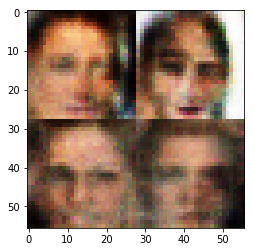

Epoch 1/1... Discriminator Loss: 1.5072... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.5371... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.5096... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.5174... Generator Loss: 0.7038


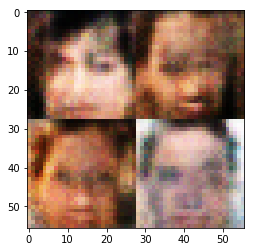

Epoch 1/1... Discriminator Loss: 1.5095... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.5148... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.5319... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.5212... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.5903... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.5464... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.5161... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.7050


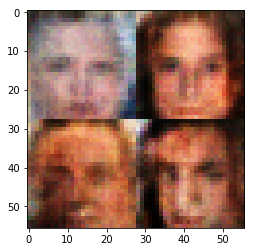

Epoch 1/1... Discriminator Loss: 1.5569... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.5081... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.5455... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.5105... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.5500... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.5090... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.5881... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.7251


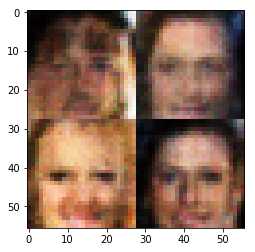

Epoch 1/1... Discriminator Loss: 1.5391... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.5314... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.5050... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.5093... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.5261... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.5515... Generator Loss: 0.6673


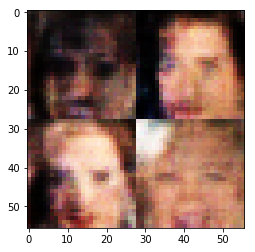

Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.4859... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.5385... Generator Loss: 0.6663


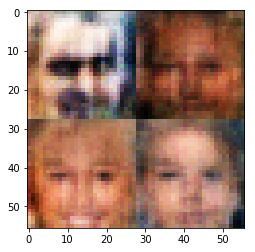

Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.5285... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.5484... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.5729... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.4961... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.4861... Generator Loss: 0.6747


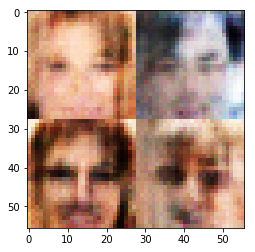

Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.5441... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.5014... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.5027... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.7464


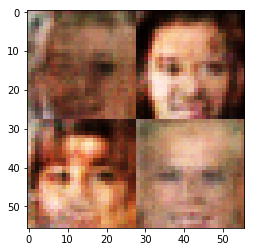

Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.4808... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.7306


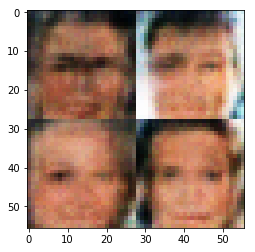

Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.7210


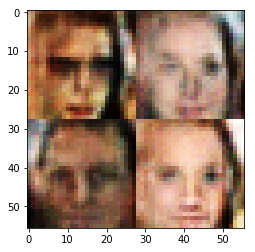

Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.5417... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.7381


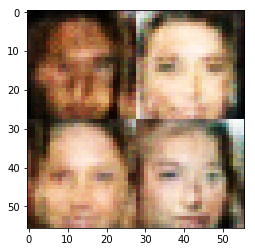

Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.7235


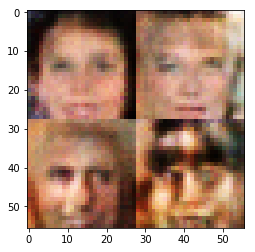

Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.7258


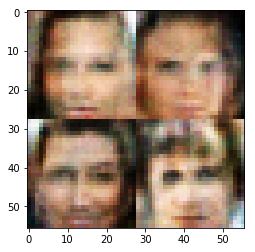

Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.6803


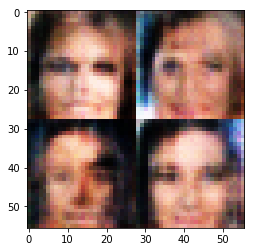

Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.7344


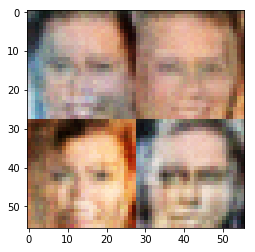

Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.7516


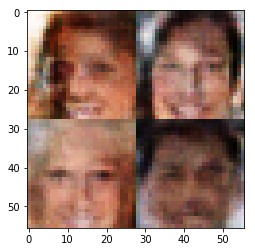

Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.7379


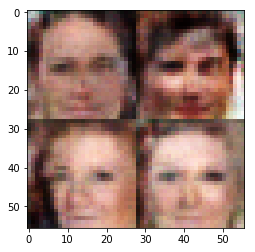

Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.7307


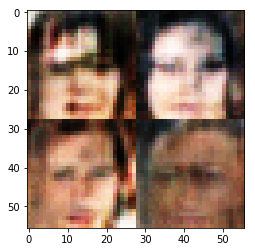

Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7774


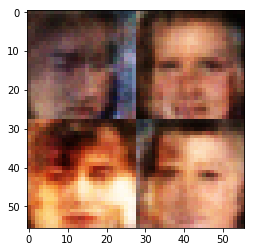

Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.4859... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.7282


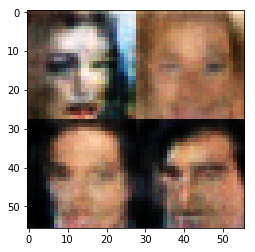

Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.7039


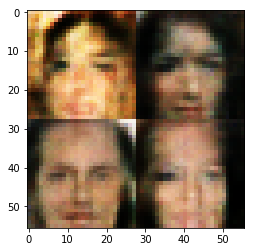

Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.7369


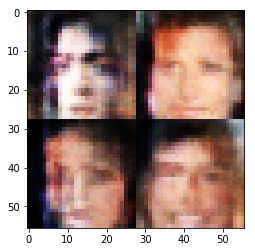

Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.7449


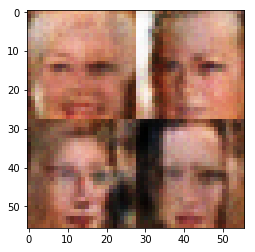

Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.7193


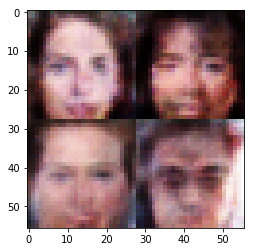

Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.7307


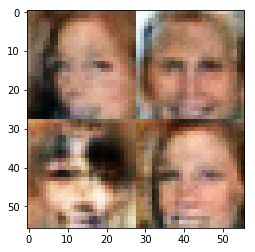

Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.7966


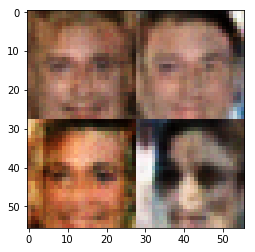

Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.8018


In [32]:
batch_size = 64
z_dim = 200
learning_rate = 0.0002
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.